# Line Spectra Estimation

Line spectral estimation seeks to
accurately recover the frequencies and amplitudes
of a signal $\mathbf{y} \in \mathbb{R}^{n}$ which consists
of a mixture of $N$ sinusoids.

Firstly the signal $\mathbf{y}$ can be generated:

In [1]:
using Pkg, Random, SparseArrays, DSP, Statistics, LinearAlgebra, FFTW

Pkg.activate("."); Pkg.instantiate();Random.seed!(39) # For reproducibility

Fs = 16e3 #sampling frequency
Nt = 2^7 #time samples
y0 = zeros(Nt)
SNR = 20
S = 4 #super-resolution factor

f_s  = range(0,  stop=Fs/2; length=div(S*Nt,2)+1)     # super resolution frequency axis
f    = range(0,  stop=Fs/2; length=div(Nt,2)+1)       # frequency axis
t  = 0:1/Fs:(Nt-1)/Fs                                 # time axis

N = 14 # number of sinusoids
Nf = div(S*Nt,4)+1
p = randperm(Nf)[1:N]

fk = f_s[p] # pick sinusoids frequencies 
A = 0.1 .* randn(N) .+ 0.7   # amplitude

for i in eachindex(fk) y0 .+= A[i].*sin.(2*pi*fk[i].*t) end # mixture of sinusoids
y = y0.+10^(-SNR/10)*sqrt(var(y0))*randn(length(y0)); # add noise

  Updating registry at `~/.julia/registries/General`
  Updating git-repo `https://github.com/JuliaRegistries/General.git`




A simple solution to estimate the frequencies is to
take the DFT or the zero-padded DFT of $\mathbf{y}$ 
where $s$ is the super-resolution factor.
However, as the following figure shows,
spectral leakage causes components at
close frequencies to merge.



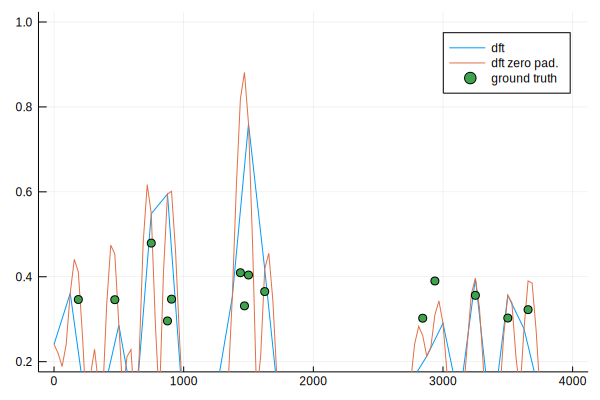

In [2]:
xzp = fft([y;zeros((S-1)*length(y))]) #zero padded signal

using Plots
plot(f,    abs.(fft(y)./Nt )[1:div(Nt,2)+1]; label = "dft", ylim=[0.2;1], xlim=[0;4e3])
plot!(f_s, abs.(xzp./Nt )[1:div(S*Nt,2)+1]; label = "dft zero pad.")
scatter!(fk, abs.(A) ./2; label = "ground truth")



This issue is not present if the following optimization problem
is solved (LASSO):

$$ \mathbf{x}_1^{\star} = \underset{\mathbf{x}}{\text{argmin}} \tfrac{1}{2} \| S F^{-1} \mathbf{x} -\mathbf{y} \|^2 + \lambda \| \mathbf{x} \|_1,  $$

where $S$ is a selection mapping and $F^{-1}$ the inverse DFT. 


In [3]:
using StructuredOptimization

x = Variable(Complex{Float64}, S*Nt) # define complex-valued variable
lambda = 1e-3*norm(xzp./(S*Nt),Inf)  # set lambda

@minimize ls(ifft(x)[1:Nt]-complex(y))+lambda*norm(x,1) with PANOC(tol = 1e-8)
x1 = copy(~x); # copy solution


The obtained solution $\mathbf{x}_1^{\star}$ is considerably more precise than before. However spurious frequencies are present and the amplitude of the frequencies is usually underestimated.


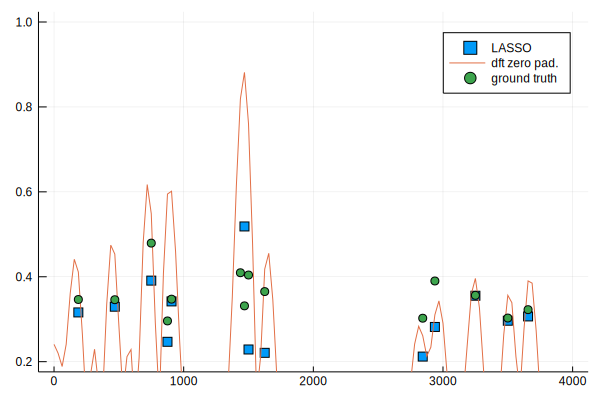

In [4]:
scatter(f_s, abs.(x1[1:div(S*Nt,2)+1]./(S*Nt) ); label = "LASSO", m=:square)
plot!(f_s, abs.(xzp[1:div(S*Nt,2)+1]./(Nt) ); label = "dft zero pad.")
scatter!(fk, abs.(A) ./2; label = "ground truth", ylim=[0.2;1], xlim=[0;4e3])

It is actually possible to refine this solution by solving the nonconvex problem:

$$ \mathbf{x}_0^{\star} = \underset{\mathbf{x}}{\text{argmin}} \tfrac{1}{2} \| S F^{-1} \mathbf{x} -\mathbf{y} \|^2  \ \text{s.t.} \ \| \mathbf{x} \|_0 \leq 2 N. $$

In [5]:
@minimize ls(ifft(x)[1:Nt]-complex(y)) st norm(x,0) <= 2*N  with PANOC(tol = 1e-8);
x0 = copy(~x);


Almost a perfect reconstruction is achieved by solving this nonconvex problem. It is important to notice that this was possible because the problem was initialized with the LASSO solution and a _good_ local minimum was reached.


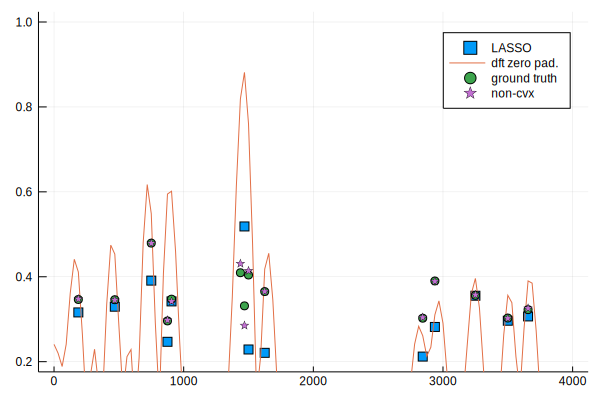

In [6]:
scatter!(f_s, abs.(x0[1:div(S*Nt,2)+1]./(S*Nt) ); label = "non-cvx", m=:star)